# Voice Recognition: Buka Tutup Classification

## Data Understanding 

### 1. Import Libraries
Import library dasar untuk analisis data dan audio processing.


In [17]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display
import IPython.display as ipd

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!



### 2. Setup Path Dataset  
Setup path dataset dan cek struktur folder dataset48k.


In [18]:
import os

# Setup dataset path
# Struktur folder: Audio/train/ dan Audio/val/ 
# Yang berisi audio_output_asep dan audio_output_yotan
# Dan setiap folder berisi folder Tutup dan Buka

parent_dataset_path = "audio"  # Path ke folder Audio

# Define paths for train and validation
train_path = os.path.join(parent_dataset_path, "train")
val_path = os.path.join(parent_dataset_path, "val")

# Define the actual class directories for train and val
train_asep_path = os.path.join(train_path, "audio_output_asep")
train_yotan_path = os.path.join(train_path, "audio_output_yotan")
val_asep_path = os.path.join(val_path, "audio_output_asep")
val_yotan_path = os.path.join(val_path, "audio_output_yotan")

def check_and_print_structure(dataset_type, dataset_path):
    """Fungsi untuk mengecek dan menampilkan struktur dataset"""
    asep_path = os.path.join(dataset_path, "audio_output_asep")
    yotan_path = os.path.join(dataset_path, "audio_output_yotan")
    
    print(f"\n📁 {dataset_type.capitalize()} Dataset Structure:")
    
    if os.path.exists(asep_path) and os.path.exists(yotan_path):
        print(f"✅ {dataset_type.capitalize()} - Asep and Yotan dataset folders found!")
        
        for speaker_folder in [asep_path, yotan_path]:
            if os.path.exists(speaker_folder):
                print(f'  {os.path.basename(speaker_folder)}/')
                for command_folder in ['Buka', 'Tutup']:
                    command_path = os.path.join(speaker_folder, command_folder)
                    if os.path.exists(command_path):
                        print(f'    {os.path.basename(command_path)}/')
                        # List first 5 files in each command folder
                        wav_files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
                        for file in wav_files[:5]:
                            print(f'      - {file}')
                        if len(wav_files) > 5:
                            print('      ...')
                        print(f'      Total files: {len(wav_files)}')
                    else:
                        print(f'    ❌ {os.path.basename(command_path)} folder not found in {os.path.basename(speaker_folder)}')
            else:
                print(f'❌ {os.path.basename(speaker_folder)} folder not found!')
    else:
        print(f"❌ {dataset_type.capitalize()} - Asep or Yotan dataset folders not found!")

# Check train dataset
check_and_print_structure("train", train_path)

# Check validation dataset  
check_and_print_structure("validation", val_path)

# Store paths for later use - now includes both train and val
data_paths = {
    'train': {
        'asep': {
            'Buka': os.path.join(train_asep_path, 'Buka'),
            'Tutup': os.path.join(train_asep_path, 'Tutup')
        },
        'yotan': {
            'Buka': os.path.join(train_yotan_path, 'Buka'),
            'Tutup': os.path.join(train_yotan_path, 'Tutup')
        }
    },
    'val': {
        'asep': {
            'Buka': os.path.join(val_asep_path, 'Buka'),
            'Tutup': os.path.join(val_asep_path, 'Tutup')
        },
        'yotan': {
            'Buka': os.path.join(val_yotan_path, 'Buka'),
            'Tutup': os.path.join(val_yotan_path, 'Tutup')
        }
    }
}

# Print summary
print("\n📊 Dataset Summary:")
for dataset_type in ['train', 'val']:
    print(f"\n{dataset_type.capitalize()} Dataset:")
    for speaker in ['asep', 'yotan']:
        for command in ['Buka', 'Tutup']:
            path = data_paths[dataset_type][speaker][command]
            if os.path.exists(path):
                file_count = len([f for f in os.listdir(path) if f.endswith('.wav')])
                print(f"  {speaker}/{command}: {file_count} files")
            else:
                print(f"  {speaker}/{command}: ❌ Path not found")

print(f"\n✅ Data paths dictionary created successfully!")
print(f"📍 You can access train data: data_paths['train']['asep']['Buka']")
print(f"📍 You can access validation data: data_paths['val']['yotan']['Tutup']")


📁 Train Dataset Structure:
✅ Train - Asep and Yotan dataset folders found!
  audio_output_asep/
    Buka/
      - buka_060.wav
      - buka_044.wav
      - buka_064.wav
      - buka_029.wav
      - buka_021.wav
      ...
      Total files: 75
    Tutup/
      - tutup_057.wav
      - tutup_033.wav
      - tutup_036.wav
      - tutup_050.wav
      - tutup_030.wav
      ...
      Total files: 75
  audio_output_yotan/
    Buka/
      - aug_3_Buka 3_p2_s1.12.wav
      - aug_1_Buka 1_p2_s1.07 copy.wav
      - aug_2_Buka 1_p2_s1.13 copy 2.wav
      - aug_4_Buka 4_p2_s0.95.wav
      - aug_4_Buka 2_p1_s0.98 copy 2.wav
      ...
      Total files: 75
    Tutup/
      - aug_1_Tutup 4_p0_s0.91.wav
      - aug_5_Tutup 2_p0_s0.97 copy.wav
      - aug_4_Tutup 3_p-1_s0.92 copy.wav
      - aug_2_Tutup 5_p1_s0.94 copy 2.wav
      - aug_4_Tutup 4_p1_s1.02 copy 2.wav
      ...
      Total files: 75

📁 Validation Dataset Structure:
✅ Validation - Asep and Yotan dataset folders found!
  audio_output_asep/



### 3. Cek Distribusi Data
Analisis distribusi file audio per kelas dan split data train/validation.


📊 DATA DISTRIBUTION

📊 VISUALIZATIONS:
--------------------------------------------------


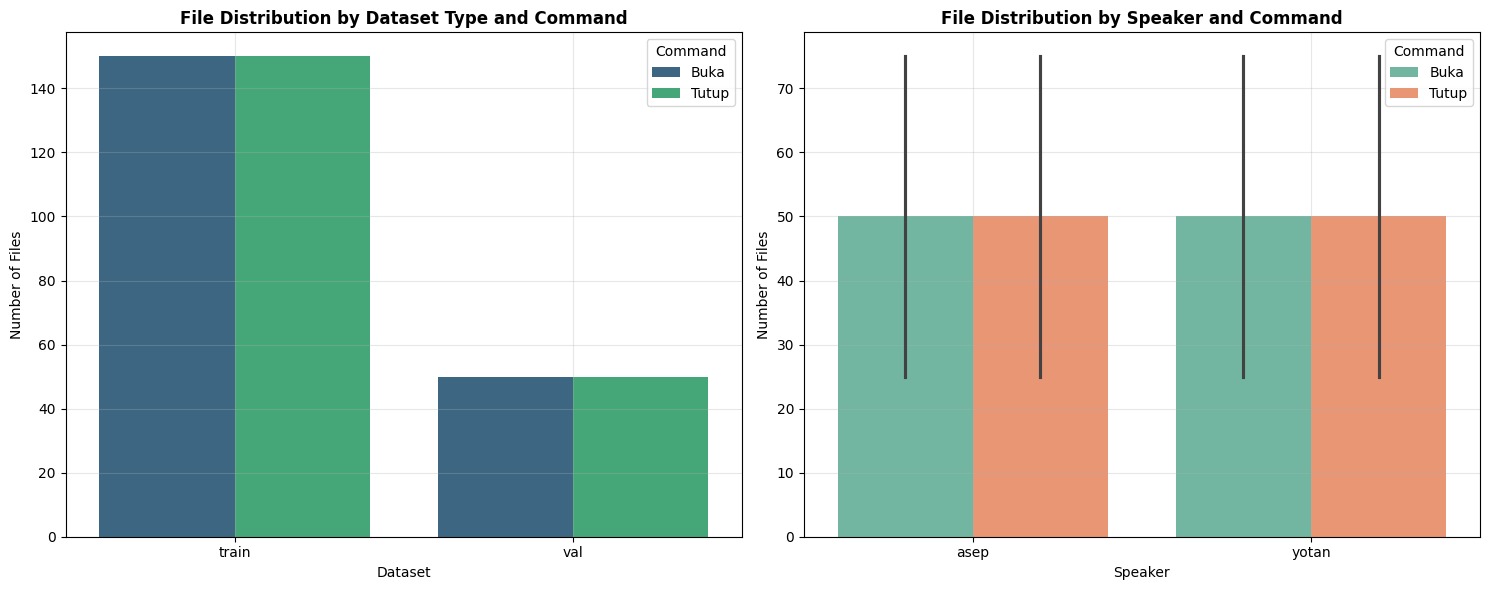

<Figure size 1200x600 with 0 Axes>

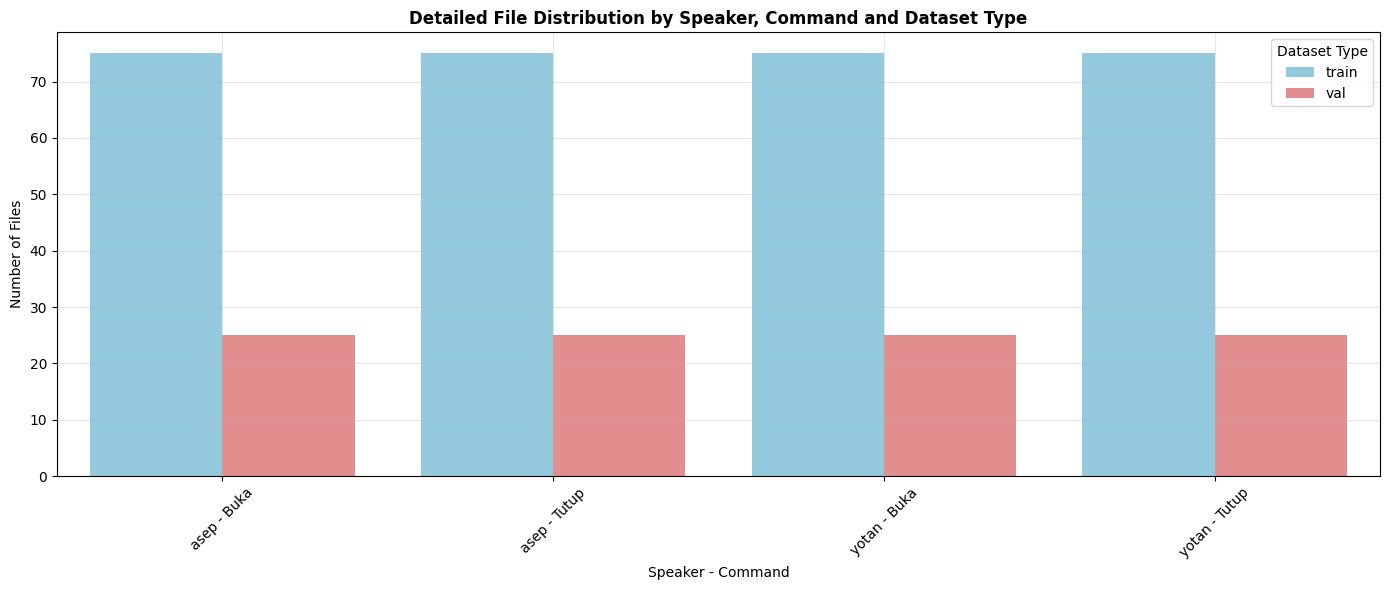


📈 DETAILED SUMMARY:

🎯 TRAIN DATASET:
------------------------------
  📁 ASEP:
    ├── Buka: 75 files (50.0%)
    ├── Tutup: 75 files (50.0%)
    └── TOTAL ASEP: 150 files
  📁 YOTAN:
    ├── Buka: 75 files (50.0%)
    ├── Tutup: 75 files (50.0%)
    └── TOTAL YOTAN: 150 files
  🎯 TOTAL TRAIN: 300 files

🎯 VAL DATASET:
------------------------------
  📁 ASEP:
    ├── Buka: 25 files (50.0%)
    ├── Tutup: 25 files (50.0%)
    └── TOTAL ASEP: 50 files
  📁 YOTAN:
    ├── Buka: 25 files (50.0%)
    ├── Tutup: 25 files (50.0%)
    └── TOTAL YOTAN: 50 files
  🎯 TOTAL VAL: 100 files

📊 OVERALL SUMMARY:
🎯 TOTAL TRAIN FILES: 300 files
🎯 TOTAL VALIDATION FILES: 100 files
🎯 COMBINED TOTAL: 400 audio files
📈 TRAIN/VAL SPLIT: 75.0% / 25.0%


In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def check_data_distribution(data_paths):
    """Check distribution of data across classes (speakers and commands) for both train and val"""
    print("📊 DATA DISTRIBUTION")
    print("=" * 50)

    distribution = {}
    total_files = 0

    # Iterate through dataset types (train, val)
    for dataset_type, speakers in data_paths.items():
        distribution[dataset_type] = {}  # Initialize dictionary for dataset type
        dataset_total = 0

        # Iterate through speakers (asep, yotan)
        for speaker_name, commands in speakers.items():
            distribution[dataset_type][speaker_name] = {}  # Initialize dictionary for speaker
            speaker_total = 0

            # Iterate through commands (Buka, Tutup)
            for command_name, command_path in commands.items():
                if os.path.exists(command_path):
                    files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
                    file_count = len(files)
                    distribution[dataset_type][speaker_name][command_name] = file_count
                    speaker_total += file_count
                    dataset_total += file_count
                    total_files += file_count
                else:
                    distribution[dataset_type][speaker_name][command_name] = 0
                    print(f"❌ Command directory not found: {command_path}")
            
            distribution[dataset_type][speaker_name]['Total'] = speaker_total  # Add speaker total
        
        distribution[dataset_type]['Dataset_Total'] = dataset_total  # Add dataset type total

    # Create visualizations
    print("\n📊 VISUALIZATIONS:")
    print("-" * 50)

    # Prepare data for plotting
    plot_data = []
    for dataset_type, speakers in distribution.items():
        for speaker, commands in speakers.items():
            if speaker != 'Dataset_Total':  # Don't include dataset total in plot data
                for command, count in commands.items():
                    if command != 'Total':  # Don't include speaker total in this plot data
                        plot_data.append({
                            'Dataset': dataset_type, 
                            'Speaker': speaker, 
                            'Command': command, 
                            'Count': count
                        })

    if plot_data:
        plot_df = pd.DataFrame(plot_data)

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Distribution by Dataset Type and Command
        sns.barplot(data=plot_df, x='Dataset', y='Count', hue='Command', 
                   palette='viridis', ax=ax1, estimator=sum, ci=None)
        ax1.set_title('File Distribution by Dataset Type and Command', fontweight='bold')
        ax1.set_ylabel('Number of Files')
        ax1.grid(True, alpha=0.3)
        ax1.legend(title='Command')

        # Plot 2: Distribution by Speaker and Command (separated by dataset type)
        sns.barplot(data=plot_df, x='Speaker', y='Count', hue='Command', 
                   palette='Set2', ax=ax2)
        ax2.set_title('File Distribution by Speaker and Command', fontweight='bold')
        ax2.set_ylabel('Number of Files')
        ax2.grid(True, alpha=0.3)
        ax2.legend(title='Command')

        plt.tight_layout()
        plt.show()

        # Additional plot: Separate bars for train and val
        plt.figure(figsize=(12, 6))
        
        # Create grouped bar plot
        plot_df_pivot = plot_df.pivot_table(
            index=['Speaker', 'Command'], 
            columns='Dataset', 
            values='Count', 
            aggfunc='sum'
        ).reset_index()

        plot_df_melted = pd.melt(
            plot_df_pivot, 
            id_vars=['Speaker', 'Command'], 
            value_vars=['train', 'val'],
            var_name='Dataset', 
            value_name='Count'
        )

        # Create grouped bar plot
        plot_df_melted['Group'] = plot_df_melted['Speaker'] + ' - ' + plot_df_melted['Command']
        
        plt.figure(figsize=(14, 6))
        sns.barplot(data=plot_df_melted, x='Group', y='Count', hue='Dataset', 
                   palette=['skyblue', 'lightcoral'])
        plt.title('Detailed File Distribution by Speaker, Command and Dataset Type', fontweight='bold')
        plt.ylabel('Number of Files')
        plt.xlabel('Speaker - Command')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.legend(title='Dataset Type')
        plt.tight_layout()
        plt.show()

    else:
        print("❌ No data to plot!")

    # Print detailed summary
    print(f"\n📈 DETAILED SUMMARY:")
    print("=" * 50)
    
    for dataset_type, speakers in distribution.items():
        print(f"\n🎯 {dataset_type.upper()} DATASET:")
        print("-" * 30)
        
        dataset_total = distribution[dataset_type]['Dataset_Total']
        
        for speaker, commands in speakers.items():
            if speaker != 'Dataset_Total':
                print(f"  📁 {speaker.upper()}:")
                speaker_total = commands['Total']
                for command, count in commands.items():
                    if command != 'Total':
                        percentage = (count / speaker_total * 100) if speaker_total > 0 else 0
                        print(f"    ├── {command}: {count} files ({percentage:.1f}%)")
                print(f"    └── TOTAL {speaker.upper()}: {speaker_total} files")
        
        print(f"  🎯 TOTAL {dataset_type.upper()}: {dataset_total} files")

    # Print overall summary
    print(f"\n📊 OVERALL SUMMARY:")
    print("=" * 30)
    print(f"🎯 TOTAL TRAIN FILES: {distribution['train']['Dataset_Total']} files")
    print(f"🎯 TOTAL VALIDATION FILES: {distribution['val']['Dataset_Total']} files")
    print(f"🎯 COMBINED TOTAL: {total_files} audio files")

    # Calculate and display split ratio
    train_total = distribution['train']['Dataset_Total']
    val_total = distribution['val']['Dataset_Total']
    
    if total_files > 0:
        train_ratio = (train_total / total_files) * 100
        val_ratio = (val_total / total_files) * 100
        print(f"📈 TRAIN/VAL SPLIT: {train_ratio:.1f}% / {val_ratio:.1f}%")

    # Return the distribution dictionary
    return distribution

# Check distribution
# Pass the data_paths dictionary to the function
data_dist = check_data_distribution(data_paths)


### 4. Contoh Audio + Metadata
Play sample audio dan visualisasi waveform + spectrogram untuk setiap kelas.


🎵 AUDIO SAMPLES & METADATA COLLECTION



🎧 SAMPLE AUDIO FILES (TRAIN DATASET ONLY):
---------------------------------------------

🎵 ASEP - BUKA Sample:
   📄 File: buka_060.wav
   👤 Speaker: asep
   🎯 Command: Buka
   📊 Dataset: train
   ⏱️ Duration: 1.70s
   🔊 Sample Rate: 48000 Hz
   ▶️ Playing audio sample...


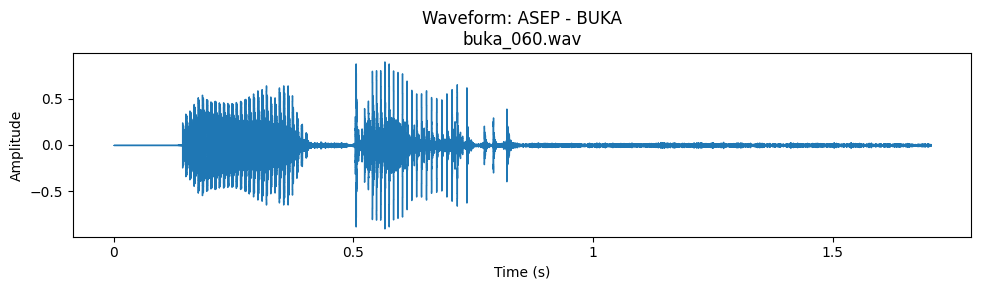


🎵 ASEP - TUTUP Sample:
   📄 File: tutup_057.wav
   👤 Speaker: asep
   🎯 Command: Tutup
   📊 Dataset: train
   ⏱️ Duration: 1.22s
   🔊 Sample Rate: 48000 Hz
   ▶️ Playing audio sample...


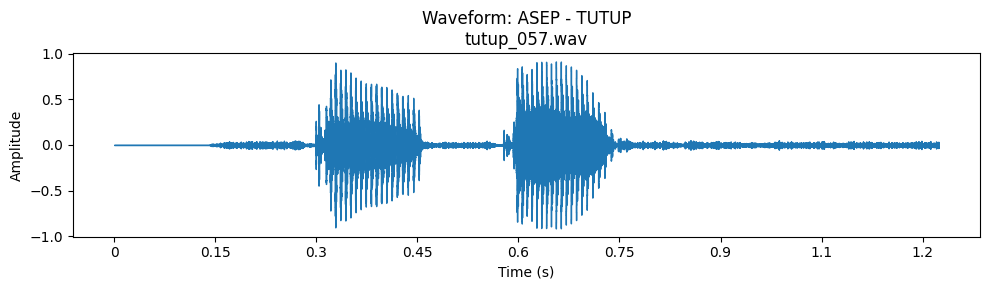


🎵 YOTAN - BUKA Sample:
   📄 File: aug_3_Buka 3_p2_s1.12.wav
   👤 Speaker: yotan
   🎯 Command: Buka
   📊 Dataset: train
   ⏱️ Duration: 1.57s
   🔊 Sample Rate: 48000 Hz
   ▶️ Playing audio sample...


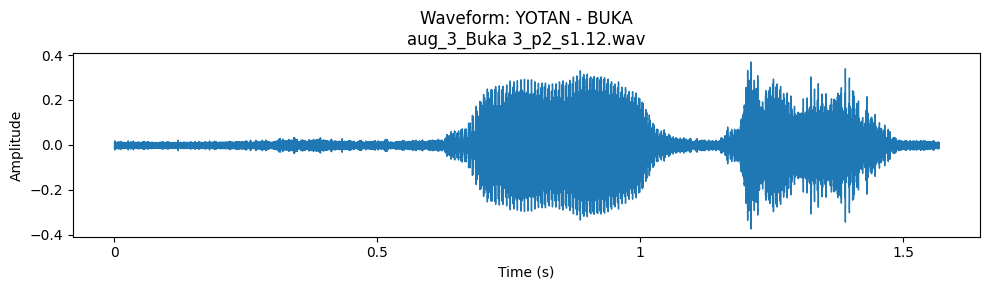


🎵 YOTAN - TUTUP Sample:
   📄 File: aug_1_Tutup 4_p0_s0.91.wav
   👤 Speaker: yotan
   🎯 Command: Tutup
   📊 Dataset: train
   ⏱️ Duration: 1.88s
   🔊 Sample Rate: 48000 Hz
   ▶️ Playing audio sample...


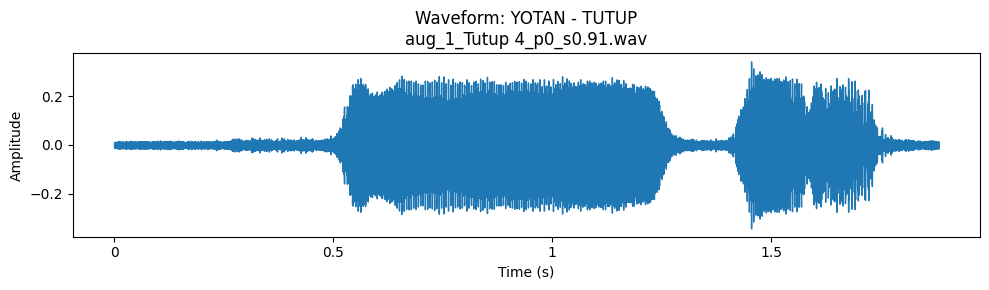


💾 METADATA SAVED TO: audio_metadata.csv
📊 Total files processed: 400

📈 DATASET BREAKDOWN:
------------------------------
   TRAIN: 300 files
   VAL: 100 files
   ASEP: 200 files
   YOTAN: 200 files
   BUKA: 200 files
   TUTUP: 200 files
📁 File size: 46.79 KB

📋 METADATA PREVIEW (ALL DATASETS):
       filename dataset_type speaker command  duration
0  buka_060.wav        train    asep    Buka     1.704
1  buka_044.wav        train    asep    Buka     1.296
2  buka_064.wav        train    asep    Buka     1.296
3  buka_029.wav        train    asep    Buka     1.296
4  buka_021.wav        train    asep    Buka     1.632
5  buka_007.wav        train    asep    Buka     1.536
6  buka_062.wav        train    asep    Buka     1.536
7  buka_063.wav        train    asep    Buka     1.704

📊 BASIC STATISTICS:
-------------------------
   Average duration: 1.65s
   Min duration: 1.21s
   Max duration: 2.32s
   Sample rates: [48000]


In [20]:
import os
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

def display_samples_and_save_metadata(data_paths):
    """Display sample audio and save all metadata to CSV for both train and val datasets"""
    print("🎵 AUDIO SAMPLES & METADATA COLLECTION")
    print("=" * 60)

    audio_metadata = []

    # Collect metadata from all files in both train and val datasets
    for dataset_type, speakers in data_paths.items():
        for speaker_name, commands in speakers.items():
            for command_name, command_path in commands.items():
                if os.path.exists(command_path):
                    files = [f for f in os.listdir(command_path) if f.endswith('.wav')]

                    for file in files:
                        file_path = os.path.join(command_path, file)
                        try:
                            y, sr = librosa.load(file_path, sr=None)
                            duration = librosa.get_duration(y=y, sr=sr)

                            metadata = {
                                'filename': file,
                                'file_path': file_path,
                                'dataset_type': dataset_type,  # Store dataset type (train/val)
                                'speaker': speaker_name,       # Store speaker name
                                'command': command_name,       # Store command name
                                'duration': duration,
                                'sample_rate': sr,
                                'num_samples': len(y)
                            }
                            audio_metadata.append(metadata)

                        except Exception as e:
                            print(f"❌ Error processing {file_path}: {e}")
                else:
                    print(f"❌ Command directory not found: {command_path}")

    # Convert to DataFrame
    metadata_df = pd.DataFrame(audio_metadata)

    if metadata_df.empty:
        print("❌ No metadata collected!")
        return pd.DataFrame()

    # Display sample audio files - ONLY FROM TRAIN DATASET
    print("\n🎧 SAMPLE AUDIO FILES (TRAIN DATASET ONLY):")
    print("-" * 45)

    # Display 1 sample from each speaker and command combination in TRAIN only
    samples_displayed = 0
    max_samples_to_display = 4  # Limit number of samples

    for speaker_name in ['asep', 'yotan']:
        for command_name in ['Buka', 'Tutup']:
            if samples_displayed >= max_samples_to_display:
                break
                
            # Hanya ambil sample dari dataset TRAIN
            sample_df = metadata_df[
                (metadata_df['dataset_type'] == 'train') & 
                (metadata_df['speaker'] == speaker_name) & 
                (metadata_df['command'] == command_name)
            ]
            
            if not sample_df.empty:
                sample = sample_df.iloc[0]
                print(f"\n🎵 {speaker_name.upper()} - {command_name.upper()} Sample:")
                print(f"   📄 File: {sample['filename']}")
                print(f"   👤 Speaker: {sample['speaker']}")
                print(f"   🎯 Command: {sample['command']}")
                print(f"   📊 Dataset: {sample['dataset_type']}")
                print(f"   ⏱️ Duration: {sample['duration']:.2f}s")
                print(f"   🔊 Sample Rate: {sample['sample_rate']} Hz")

                # Play audio
                try:
                    y, sr = librosa.load(sample['file_path'], sr=None)
                    print(f"   ▶️ Playing audio sample...")
                    ipd.display(ipd.Audio(y, rate=sr))
                    
                    # Display waveform
                    plt.figure(figsize=(10, 3))
                    librosa.display.waveshow(y, sr=sr)
                    plt.title(f"Waveform: {speaker_name.upper()} - {command_name.upper()}\n{sample['filename']}")
                    plt.xlabel("Time (s)")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()
                    
                except Exception as e:
                    print(f"❌ Error playing audio: {e}")
                
                samples_displayed += 1
            else:
                print(f"\n⏭️ Skipping sample display for {speaker_name} - {command_name} (no data found in train dataset)")

    # Save to CSV (masih menyimpan semua metadata termasuk val)
    csv_filename = "audio_metadata.csv"
    metadata_df.to_csv(csv_filename, index=False)

    print(f"\n💾 METADATA SAVED TO: {csv_filename}")
    print(f"📊 Total files processed: {len(metadata_df)}")
    
    # Show dataset breakdown
    print(f"\n📈 DATASET BREAKDOWN:")
    print("-" * 30)
    for dataset_type in ['train', 'val']:
        dataset_count = len(metadata_df[metadata_df['dataset_type'] == dataset_type])
        print(f"   {dataset_type.upper()}: {dataset_count} files")
    
    for speaker in ['asep', 'yotan']:
        speaker_count = len(metadata_df[metadata_df['speaker'] == speaker])
        print(f"   {speaker.upper()}: {speaker_count} files")
    
    for command in ['Buka', 'Tutup']:
        command_count = len(metadata_df[metadata_df['command'] == command])
        print(f"   {command.upper()}: {command_count} files")

    if os.path.exists(csv_filename):
        file_size_kb = os.path.getsize(csv_filename) / 1024
        print(f"📁 File size: {file_size_kb:.2f} KB")

    # Show detailed preview
    print(f"\n📋 METADATA PREVIEW (ALL DATASETS):")
    print(metadata_df[['filename', 'dataset_type', 'speaker', 'command', 'duration']].head(8))

    # Display basic statistics
    print(f"\n📊 BASIC STATISTICS:")
    print("-" * 25)
    print(f"   Average duration: {metadata_df['duration'].mean():.2f}s")
    print(f"   Min duration: {metadata_df['duration'].min():.2f}s")
    print(f"   Max duration: {metadata_df['duration'].max():.2f}s")
    print(f"   Sample rates: {metadata_df['sample_rate'].unique()}")

    return metadata_df

# Run the function
# Pass the data_paths dictionary to the function
metadata_df = display_samples_and_save_metadata(data_paths)


### 5. Analisis Durasi dan Sample Rate
Analisis statistik durasi audio dan konsistensi sample rate dataset.


⏱️ DURATION & SAMPLE RATE ANALYSIS


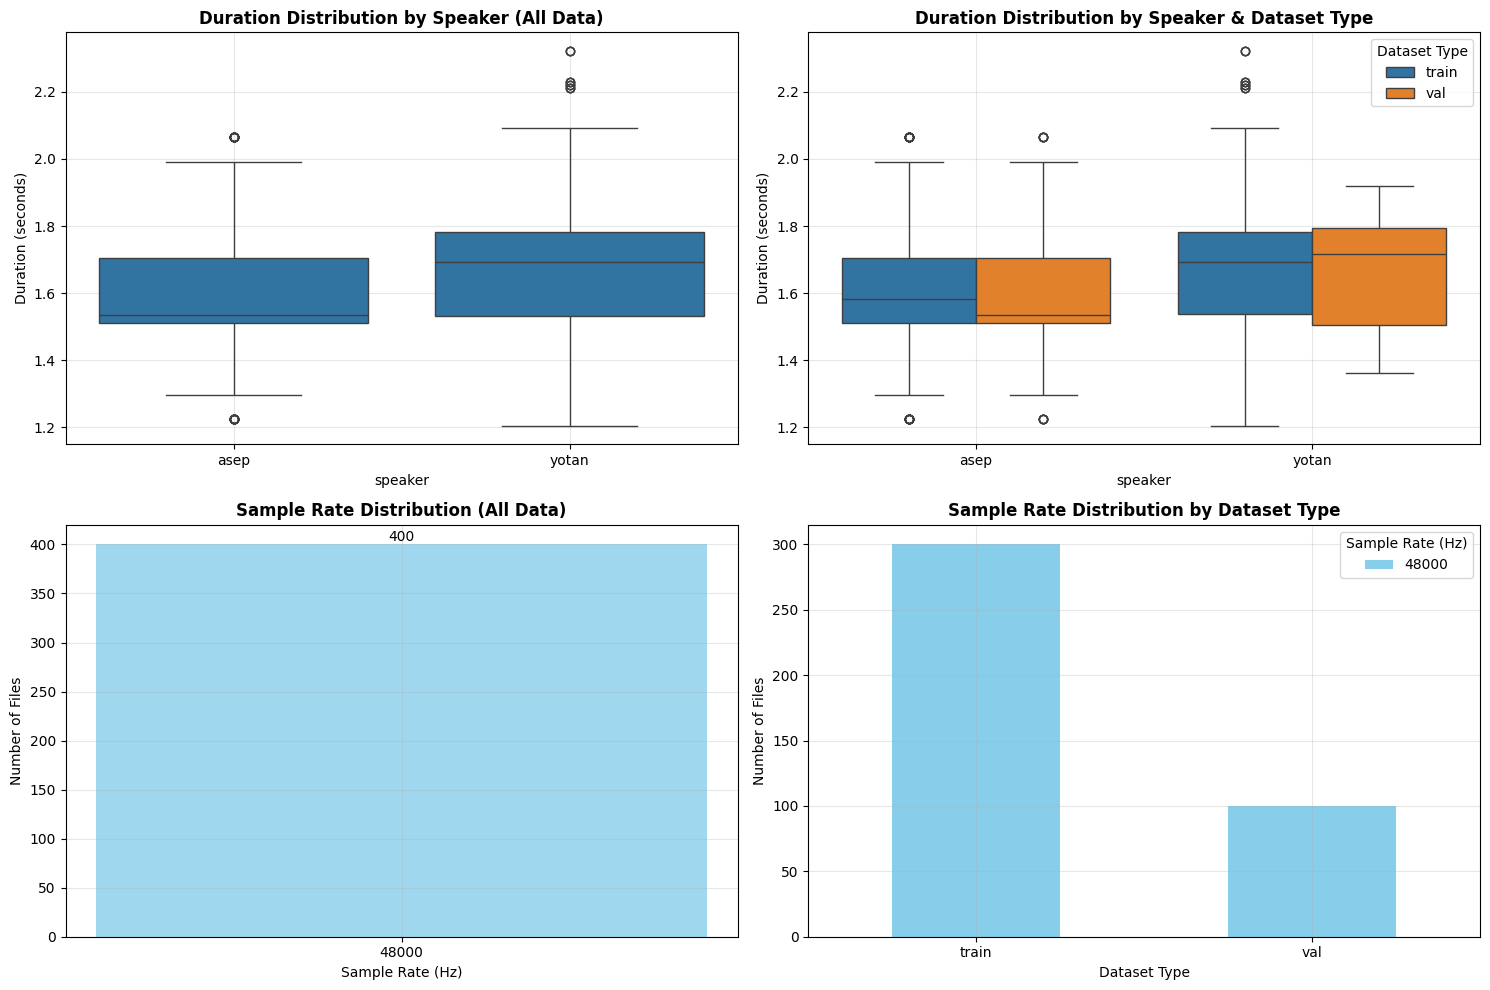


📊 DURATION STATISTICS (ALL DATA):
-----------------------------------
         count   mean    std    min    25%    50%    75%    max
speaker                                                        
asep     200.0  1.616  0.255  1.224  1.512  1.536  1.704  2.064
yotan    200.0  1.684  0.227  1.206  1.532  1.692  1.781  2.321

📈 OVERALL DURATION STATISTICS:
   Mean: 1.650s
   Std:  0.243s
   Min:  1.206s
   Max:  2.321s

📊 DURATION STATISTICS BY DATASET TYPE:
----------------------------------------

🎯 TRAIN DATASET:
         count   mean    std    min    25%    50%    75%    max
speaker                                                        
asep     150.0  1.618  0.254  1.224  1.512  1.584  1.704  2.064
yotan    150.0  1.694  0.240  1.206  1.537  1.692  1.781  2.321

🎯 VAL DATASET:
         count   mean    std    min    25%    50%    75%    max
speaker                                                        
asep      50.0  1.609  0.260  1.224  1.512  1.536  1.704  2.064
yotan     50.0

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

def analyze_duration_sample_rate(audio_df):
    """Analyze duration and sample rate distribution from the dataframe"""
    print("⏱️ DURATION & SAMPLE RATE ANALYSIS")
    print("=" * 50)

    if audio_df.empty:
        print("❌ No audio data for analysis!")
        return pd.DataFrame()

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Duration distribution by speaker (all datasets)
    if 'speaker' in audio_df.columns and 'duration' in audio_df.columns:
        sns.boxplot(data=audio_df, x='speaker', y='duration', ax=axes[0, 0])
        axes[0, 0].set_title('Duration Distribution by Speaker (All Data)', fontweight='bold')
        axes[0, 0].set_ylabel('Duration (seconds)')
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].set_title('Duration Analysis N/A', fontweight='bold')
        axes[0, 0].text(0.5, 0.5, 'Required columns not found', horizontalalignment='center', verticalalignment='center', transform=axes[0, 0].transAxes)

    # Plot 2: Duration distribution by speaker and dataset type
    if 'speaker' in audio_df.columns and 'duration' in audio_df.columns and 'dataset_type' in audio_df.columns:
        sns.boxplot(data=audio_df, x='speaker', y='duration', hue='dataset_type', ax=axes[0, 1])
        axes[0, 1].set_title('Duration Distribution by Speaker & Dataset Type', fontweight='bold')
        axes[0, 1].set_ylabel('Duration (seconds)')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].legend(title='Dataset Type')
    else:
        axes[0, 1].set_title('Duration by Dataset N/A', fontweight='bold')
        axes[0, 1].text(0.5, 0.5, 'Required columns not found', horizontalalignment='center', verticalalignment='center', transform=axes[0, 1].transAxes)

    # Plot 3: Sample rate distribution
    if 'sample_rate' in audio_df.columns:
        sample_rate_counts = audio_df['sample_rate'].value_counts().sort_index()
        bars = axes[1, 0].bar(sample_rate_counts.index.astype(str), sample_rate_counts.values, color='skyblue', alpha=0.8)
        axes[1, 0].set_title('Sample Rate Distribution (All Data)', fontweight='bold')
        axes[1, 0].set_xlabel('Sample Rate (Hz)')
        axes[1, 0].set_ylabel('Number of Files')
        axes[1, 0].grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, value in zip(bars, sample_rate_counts.values):
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                           str(value), ha='center', va='bottom')
    else:
        axes[1, 0].set_title('Sample Rate Analysis N/A', fontweight='bold')
        axes[1, 0].text(0.5, 0.5, 'Required columns not found', horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)

    # Plot 4: Sample rate by dataset type
    if 'sample_rate' in audio_df.columns and 'dataset_type' in audio_df.columns:
        sample_rate_by_dataset = audio_df.groupby(['dataset_type', 'sample_rate']).size().unstack(fill_value=0)
        sample_rate_by_dataset.plot(kind='bar', ax=axes[1, 1], color=['skyblue', 'lightcoral'])
        axes[1, 1].set_title('Sample Rate Distribution by Dataset Type', fontweight='bold')
        axes[1, 1].set_xlabel('Dataset Type')
        axes[1, 1].set_ylabel('Number of Files')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].legend(title='Sample Rate (Hz)')
        plt.xticks(rotation=0)
    else:
        axes[1, 1].set_title('Sample Rate by Dataset N/A', fontweight='bold')
        axes[1, 1].text(0.5, 0.5, 'Required columns not found', horizontalalignment='center', verticalalignment='center', transform=axes[1, 1].transAxes)

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    if 'speaker' in audio_df.columns and 'duration' in audio_df.columns:
        print("\n📊 DURATION STATISTICS (ALL DATA):")
        print("-" * 35)
        duration_stats = audio_df.groupby('speaker')['duration'].describe()
        print(duration_stats.round(3))
        
        # Overall statistics
        print(f"\n📈 OVERALL DURATION STATISTICS:")
        print(f"   Mean: {audio_df['duration'].mean():.3f}s")
        print(f"   Std:  {audio_df['duration'].std():.3f}s")
        print(f"   Min:  {audio_df['duration'].min():.3f}s")
        print(f"   Max:  {audio_df['duration'].max():.3f}s")

    # Statistics by dataset type
    if 'dataset_type' in audio_df.columns and 'duration' in audio_df.columns:
        print(f"\n📊 DURATION STATISTICS BY DATASET TYPE:")
        print("-" * 40)
        for dataset_type in ['train', 'val']:
            dataset_data = audio_df[audio_df['dataset_type'] == dataset_type]
            if not dataset_data.empty:
                print(f"\n🎯 {dataset_type.upper()} DATASET:")
                dataset_stats = dataset_data.groupby('speaker')['duration'].describe()
                print(dataset_stats.round(3))

    if 'sample_rate' in audio_df.columns:
        print(f"\n🎯 SAMPLE RATES ANALYSIS:")
        print("-" * 25)
        print(f"Unique sample rates: {audio_df['sample_rate'].unique()}")
        
        # Sample rate distribution
        sample_rate_dist = audio_df['sample_rate'].value_counts().sort_index()
        for sr, count in sample_rate_dist.items():
            percentage = (count / len(audio_df)) * 100
            print(f"  {sr} Hz: {count} files ({percentage:.1f}%)")
        
        # Sample rate by dataset type
        if 'dataset_type' in audio_df.columns:
            print(f"\n📊 SAMPLE RATE BY DATASET TYPE:")
            for dataset_type in ['train', 'val']:
                dataset_data = audio_df[audio_df['dataset_type'] == dataset_type]
                if not dataset_data.empty:
                    sr_dist = dataset_data['sample_rate'].value_counts().sort_index()
                    print(f"  {dataset_type.upper()}:")
                    for sr, count in sr_dist.items():
                        percentage = (count / len(dataset_data)) * 100
                        print(f"    {sr} Hz: {count} files ({percentage:.1f}%)")

    return audio_df

# Analyze duration and sample rate - use the dataframe already created
# Check if metadata_df exists and is not empty before calling
if 'metadata_df' in locals() and not metadata_df.empty:
    audio_df = analyze_duration_sample_rate(metadata_df)
else:
    print("❌ metadata_df not available for duration and sample rate analysis.")
    audio_df = pd.DataFrame() # Ensure audio_df is defined even if metadata_df is not


### 6. Deteksi Missing Value dan Outlier
Deteksi masalah data seperti missing values dan outlier durasi audio.


In [22]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import librosa

def detect_missing_values_outliers(data_paths):
    """Detect missing values and outliers in audio dataset for both train and val"""
    print("🔍 DETECTING MISSING VALUES & OUTLIERS")
    print("=" * 60)
    
    # Collect basic metadata from both train and val datasets
    metadata_list = []
    
    for dataset_type, speakers in data_paths.items():
        for speaker_name, commands in speakers.items():
            for command_name, command_path in commands.items():
                if os.path.exists(command_path):
                    wav_files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
                    
                    for file in wav_files:
                        file_path = os.path.join(command_path, file)
                        
                        try:
                            y, sr = librosa.load(file_path, sr=None)
                            duration = librosa.get_duration(y=y, sr=sr)
                            
                            metadata = {
                                'filename': file,
                                'dataset_type': dataset_type,
                                'speaker': speaker_name,
                                'command': command_name,
                                'duration': duration,
                                'sample_rate': sr,
                                'num_samples': len(y),
                                'rms_energy': np.sqrt(np.mean(y**2))
                            }
                            metadata_list.append(metadata)
                            
                        except Exception as e:
                            print(f"❌ Error processing {file_path}: {e}")
                            continue
    
    # Create DataFrame
    metadata_df = pd.DataFrame(metadata_list)
    
    if metadata_df.empty:
        print("❌ No data collected for analysis!")
        return pd.DataFrame()
    
    print(f"\n📊 DATASET SHAPE: {metadata_df.shape}")
    print(f"📁 Total files: {len(metadata_df)}")
    
    # Dataset breakdown
    print(f"\n📈 DATASET BREAKDOWN:")
    for dataset_type in ['train', 'val']:
        count = len(metadata_df[metadata_df['dataset_type'] == dataset_type])
        print(f"   {dataset_type.upper()}: {count} files")
    
    # 1. MISSING VALUES DETECTION
    print("\n❌ MISSING VALUES ANALYSIS:")
    print("-" * 35)
    missing_data = metadata_df.isnull().sum()
    missing_percent = (missing_data / len(metadata_df)) * 100
    
    missing_info = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percent
    })
    
    # Filter only columns with missing values
    missing_info = missing_info[missing_info['Missing Count'] > 0]
    
    if missing_info.empty:
        print("✅ No missing values found!")
    else:
        print(missing_info)
    
    # 2. OUTLIER DETECTION
    print("\n📈 OUTLIER DETECTION (using IQR method):")
    print("-" * 45)
    
    numerical_cols = ['duration', 'sample_rate', 'num_samples', 'rms_energy']
    numerical_cols = [col for col in numerical_cols if col in metadata_df.columns]
    
    outlier_summary = {}
    
    for col in numerical_cols:
        Q1 = metadata_df[col].quantile(0.25)
        Q3 = metadata_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = metadata_df[(metadata_df[col] < lower_bound) | (metadata_df[col] > upper_bound)]
        
        outlier_summary[col] = {
            'count': len(outliers),
            'percentage': len(outliers)/len(metadata_df)*100,
            'bounds': [lower_bound, upper_bound],
            'outliers': outliers
        }
        
        print(f"\n📊 {col.upper()}:")
        print(f"   Q1: {Q1:.4f}, Q3: {Q3:.4f}, IQR: {IQR:.4f}")
        print(f"   Bounds: [{lower_bound:.4f}, {upper_bound:.4f}]")
        print(f"   Outliers: {len(outliers)} files ({len(outliers)/len(metadata_df)*100:.1f}%)")
        
        if len(outliers) > 0:
            print(f"   Outlier files (first 3):")
            for i, (_, row) in enumerate(outliers.head(3).iterrows()):
                print(f"     - {row['filename']} ({row['dataset_type']} - {row['speaker']} - {row['command']})")
            if len(outliers) > 3:
                print(f"     ... and {len(outliers) - 3} more")
    
    # 3. OUTLIER ANALYSIS BY DATASET TYPE
    print(f"\n🎯 OUTLIER ANALYSIS BY DATASET TYPE:")
    print("-" * 40)
    
    for dataset_type in ['train', 'val']:
        dataset_data = metadata_df[metadata_df['dataset_type'] == dataset_type]
        if len(dataset_data) > 0:
            print(f"\n📁 {dataset_type.upper()} DATASET:")
            for col in numerical_cols:
                Q1 = dataset_data[col].quantile(0.25)
                Q3 = dataset_data[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers = dataset_data[(dataset_data[col] < lower_bound) | (dataset_data[col] > upper_bound)]
                
                print(f"   {col}: {len(outliers)} outliers ({len(outliers)/len(dataset_data)*100:.1f}%)")
    
    # 4. SUMMARY STATISTICS
    print(f"\n📊 SUMMARY STATISTICS FOR NUMERICAL COLUMNS:")
    print("-" * 45)
    
    stats_df = metadata_df[numerical_cols].describe()
    print(stats_df.round(4))
    
    # 5. DURATION OUTLIERS DETAILED ANALYSIS
    if 'duration' in numerical_cols:
        print(f"\n⏱️ DURATION OUTLIERS DETAILED ANALYSIS:")
        print("-" * 40)
        
        duration_outliers = outlier_summary['duration']['outliers']
        if len(duration_outliers) > 0:
            print("Files with unusual durations:")
            for _, row in duration_outliers.iterrows():
                print(f"   {row['filename']}: {row['duration']:.3f}s ({row['dataset_type']} - {row['speaker']} - {row['command']})")
        else:
            print("✅ No duration outliers found!")
    
    # 6. SAMPLE RATE CONSISTENCY CHECK
    if 'sample_rate' in metadata_df.columns:
        print(f"\n🔊 SAMPLE RATE CONSISTENCY CHECK:")
        print("-" * 35)
        sample_rates = metadata_df['sample_rate'].unique()
        print(f"Unique sample rates: {sample_rates}")
        
        if len(sample_rates) == 1:
            print("✅ All files have consistent sample rate!")
        else:
            print("⚠️  Multiple sample rates detected:")
            for sr in sample_rates:
                count = len(metadata_df[metadata_df['sample_rate'] == sr])
                print(f"   {sr} Hz: {count} files")
    
    print(f"\n✅ MISSING VALUES & OUTLIERS ANALYSIS COMPLETED!")
    print(f"📊 Total files analyzed: {len(metadata_df)}")
    print(f"📁 Train files: {len(metadata_df[metadata_df['dataset_type'] == 'train'])}")
    print(f"📁 Validation files: {len(metadata_df[metadata_df['dataset_type'] == 'val'])}")
    
    return metadata_df

# Run detection
metadata_df = detect_missing_values_outliers(data_paths)

🔍 DETECTING MISSING VALUES & OUTLIERS

📊 DATASET SHAPE: (400, 8)
📁 Total files: 400

📈 DATASET BREAKDOWN:
   TRAIN: 300 files
   VAL: 100 files

❌ MISSING VALUES ANALYSIS:
-----------------------------------
✅ No missing values found!

📈 OUTLIER DETECTION (using IQR method):
---------------------------------------------

📊 DURATION:
   Q1: 1.5120, Q3: 1.7677, IQR: 0.2557
   Bounds: [1.1284, 2.1513]
   Outliers: 12 files (3.0%)
   Outlier files (first 3):
     - aug_5_Buka 5_p1_s0.94 copy.wav (train - yotan - Buka)
     - aug_2_Buka 5_p-1_s0.90.wav (train - yotan - Buka)
     - aug_3_Buka 5_p1_s0.94.wav (train - yotan - Buka)
     ... and 9 more

📊 SAMPLE_RATE:
   Q1: 48000.0000, Q3: 48000.0000, IQR: 0.0000
   Bounds: [48000.0000, 48000.0000]
   Outliers: 0 files (0.0%)

📊 NUM_SAMPLES:
   Q1: 72576.0000, Q3: 84851.0000, IQR: 12275.0000
   Bounds: [54163.5000, 103263.5000]
   Outliers: 12 files (3.0%)
   Outlier files (first 3):
     - aug_5_Buka 5_p1_s0.94 copy.wav (train - yotan - Buka